<a href="https://colab.research.google.com/github/Biniyamgd/IDP/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#progress

!pip install dlib
!pip install face_recognition
from google.colab import drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=811ea46001b4e2066b9504eacc2cb045b664ac870cca294d0287cc400c9be177
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
Mounted at /content/drive


In [2]:
import firebase_admin
from firebase_admin import credentials

cred = credentials.Certificate("/content/drive/MyDrive/serviceAccountKey.json")
firebase_admin.initialize_app(cred,{
    "databaseURL":"https://facerecondb-default-rtdb.firebaseio.com/",
    "storageBucket":"facerecondb.appspot.com"
})

In [3]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

!mkdir unknown

def take_photo(filename='./unknown/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

{'Total_attendace': 8, 'Year': 4, 'last_attendance_time': '2024-12-12 00:00:00', 'major': 'Computer', 'name': 'Biniyam Gedefaw', 'starting_year': 2021}


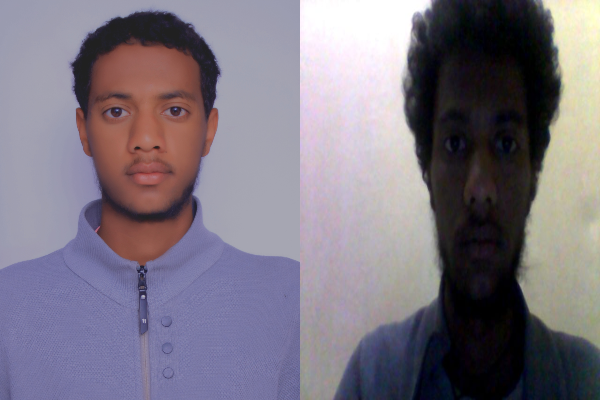

In [13]:
from IPython.display import Image, clear_output
from google.colab.patches import cv2_imshow

from threading import local
import cv2
import os
import pickle
import face_recognition
import numpy as np
import firebase_admin
from firebase_admin import storage
from firebase_admin import db
import time

Retake()

def Retake():
 try:
   filename = take_photo()
   print('Saved to {}'.format(filename))

   # Show the image which was just taken.
   # display(Image(filename))  #check
 except Exception as err:
   # Errors will be thrown if the user does not have a webcam or if they do not
   # grant the page permission to access it.
   print(str(err))



 filepath='./drive/MyDrive/students'
 folder=os.listdir(filepath)
 modelist=[]
 studentId=[]


 for Path in folder:
  # Check if the item is a file and a supported image format before adding to modelist
  if os.path.isfile(os.path.join(filepath, Path)) and Path.lower().endswith(('.png', '.jpg', '.jpeg')):
    modelist.append(cv2.imread(os.path.join(filepath,Path)))
    studentId.append(os.path.splitext(Path)[0])
    imgfile=os.path.join(filepath,Path)
    # Get the relative path to avoid including parent directories
    relative_path = os.path.relpath(imgfile, filepath)
    bucket=storage.bucket()
    blob = bucket.blob(relative_path)
    blob.upload_from_filename(imgfile)
    print(f'File {imgfile} uploaded to {relative_path}.')
 print(studentId)

 encodeList=[]
 def encodingImg(imgList): # Changed function parameter to imgList to reflect that it's processing a list

    for img in imgList: # Iterate over each image in the list
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        encode=face_recognition.face_encodings(img) # Use img instead of i
        encodeList.append(encode)
    return encodeList

 print('encoding Started...')
 encodes=encodingImg(modelist) # Pass the list of images
 unknownId=[encodes[0],studentId]
 print('encoding Complete...')
 # print(unknownId)

 file =open('./sample_data/encoding.p','wb')
 pickle.dump(unknownId,file)
 file.close()
 print('File Saved')

 file = open('./sample_data/encoding.p','rb')
 encodeListknownId=pickle.load(file)
 file.close()
 un , std = encodeListknownId
 print(std)



 # print(modelist)
 filepath2=cv2.imread(os.path.join('/content/unknown','photo.jpg'))

 def encodingImg2(img): # Changed function parameter to imgList to reflect that it's processing a list
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        encode=face_recognition.face_encodings(img) # Use img instead of i
        return encode

 encodehello = encodingImg2(filepath2)
 i=0
 Matches=[]
 FaceDistance=[]
 try:
   while i<len(encodes):
    for items in encodes[i]:
      match1=face_recognition.compare_faces(items,encodehello)
      facedis=face_recognition.face_distance(items,encodehello)
      Matches.append(match1[0])
      FaceDistance.append(facedis[0])
      i=i+1
 except Exception:
  print("Retake The Photo Please")
  Retake()
 print(Matches)
 print(FaceDistance)
 if True in Matches:

   delay=3
   checked=cv2.imread('/content/drive/MyDrive/display/checked.jpg')
   cv2_imshow(checked)
   time.sleep(delay)
   clear_output()

   index=np.argmin(FaceDistance)
   ID=studentId[index]
   IDref=db.reference(f'students/{ID}')
   print(IDref.get())
   Downblob=bucket.get_blob(f'{ID}.jpg')
   array=np.frombuffer(Downblob.download_as_string(),np.uint8)
   image1=cv2.imdecode(array,cv2.IMREAD_COLOR)
   # Load the images
   img2 = cv2.imread('./unknown/photo.jpg')

   # Resize the images to the same size (if needed)
   img1 = cv2.resize(image1, (300, 400))
   img2 = cv2.resize(img2, (300, 400))

   # Concatenate the images horizontally
   img_combined = cv2.hconcat([img1, img2])
   # Display the combined image
   cv2_imshow(img_combined)

   # Wait for the user to close the window
   # cv2.waitKey(0)
   # cv2.destroyAllWindows()
 else:
   cv2

TypeError: Image data of dtype object cannot be converted to float

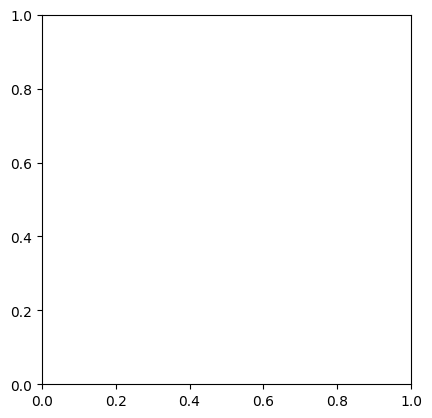

In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
img= cv2.imread('./photo.jpg')
plt.imshow(img)
plt.show

In [ ]:
import cv2
import os
import face_recognition

filepath='./'
folder=os.listdir(filepath)
modelist=[]
stuid=[]
encodeList=[]
for Path in folder:
  # if os.path.isfile(os.path.join(filepath, Path)) and Path.lower().endswith(('.png', '.jpg', '.jpeg')):
    modelist.append(cv2.imread(os.path.join(filepath,Path)))

print(modelist[3])


def encodingImg(Img):
  # for img in Img:
    img=cv2.cvtColor(Img,cv2.COLOR_BGR2RGB)
    encode=face_recognition.face_encodings(img)
    encodeList.append(encode)
    return encodeList

print('encoding Started...')
encodes=encodingImg(modelist[2])
print('encoding Complete...')
print(encodes)

None
encoding Started...


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [1]:
                # Update data of attendance
                datetimeObject = datetime.strptime(studentInfo['last_attendance_time'],
                                                   "%Y-%m-%d %H:%M:%S")
                secondsElapsed = (datetime.now() - datetimeObject).total_seconds()
                print(secondsElapsed)
                if secondsElapsed > 30:
                    ref = db.reference(f'Students/{id}')
                    studentInfo['total_attendance'] += 1
                    ref.child('total_attendance').set(studentInfo['total_attendance'])
                    ref.child('last_attendance_time').set(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

FileNotFoundError: [Errno 2] No such file or directory: 'encodeGenerator.py'

In [ ]:
from threading import local
import cv2
import os
import pickle
import face_recognition
import numpy as np
import firebase_admin
from firebase_admin import storage
from firebase_admin import credentials
from firebase_admin import db

# cred = credentials.Certificate("/content/drive/MyDrive/serviceAccountKey.json")
# firebase_admin.initialize_app(cred,{
#     "databaseURL":"https://facerecondb-default-rtdb.firebaseio.com/",
#     "storageBucket":"facerecondb.appspot.com"
# })


filepath='./drive/MyDrive/students'
folder=os.listdir(filepath)
modelist=[]
studentId=[]


for Path in folder:
  # Check if the item is a file and a supported image format before adding to modelist
  if os.path.isfile(os.path.join(filepath, Path)) and Path.lower().endswith(('.png', '.jpg', '.jpeg')):
    modelist.append(cv2.imread(os.path.join(filepath,Path)))
    studentId.append(os.path.splitext(Path)[0])
    imgfile=os.path.join(filepath,Path)
    # Get the relative path to avoid including parent directories
    relative_path = os.path.relpath(imgfile, filepath)
    bucket=storage.bucket()
    blob = bucket.blob(relative_path)
    blob.upload_from_filename(imgfile)
    print(f'File {imgfile} uploaded to {relative_path}.')
print(studentId)

encodeList=[]
def encodingImg(imgList): # Changed function parameter to imgList to reflect that it's processing a list

    for img in imgList: # Iterate over each image in the list
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        encode=face_recognition.face_encodings(img) # Use img instead of i
        encodeList.append(encode)
    return encodeList

print('encoding Started...')
encodes=encodingImg(modelist) # Pass the list of images
unknownId=[encodes[0],studentId]
print('encoding Complete...')
# print(unknownId)

file =open('./sample_data/encoding.p','wb')
pickle.dump(unknownId,file)
file.close()
print('File Saved')

file = open('./sample_data/encoding.p','rb')
encodeListknownId=pickle.load(file)
file.close()
un , std =encodeListknownId
print(std)



# print(modelist)
filepath2=cv2.imread(os.path.join('/content/unknown','photo.jpg'))

encodeList2=[]
def encodingImg2(img): # Changed function parameter to imgList to reflect that it's processing a list
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        encode=face_recognition.face_encodings(img) # Use img instead of i
        return encode

encodehello = encodingImg2(filepath2)
i=0
arr1=[]
arr2=[]
while i<len(encodes):
 for items in encodes[i]:
   match1=face_recognition.compare_faces(items,encodehello)
   facedis=face_recognition.face_distance(items,encodehello)
   arr1.append(match1[0])
   arr2.append(facedis[0])
   i=i+1
print(arr1)
print(arr2)
index=np.argmin(arr2)
ID=studentId[index]
IDref=db.reference(f'students/{ID}')
print(IDref.get())
Downblob=bucket.get_blob(f'./{ID}.jpg')


File ./drive/MyDrive/students/0273.jpg uploaded to 0273.jpg.
File ./drive/MyDrive/students/1316.jpg uploaded to 1316.jpg.
['0273', '1316']
encoding Started...
encoding Complete...
File Saved
['0273', '1316']
[True, False]
[0.4679978449691711, 0.6433578062293922]
{'Total_attendace': 8, 'Year': 4, 'last_attendance_time': '2024-12-12 00:00:00', 'major': 'Computer', 'name': 'Biniyam Gedefaw', 'starting_year': 2021}


In [ ]:

import firebase_admin
from firebase_admin import credentials
from firebase_admin import db



cred = credentials.Certificate("/content/drive/MyDrive/serviceAccountKey.json")
firebase_admin.initialize_app(cred,{
    "databaseURL":"https://facerecondb-default-rtdb.firebaseio.com/"
})

ref=db.reference('students')


data= {
"1316":{
    "name":"Yihun Melkam",
    "major":"Computer",
    "starting_year":2021,
    "Total_attendace":9,
    "Year":4,
    "last_attendance_time":"2024-12-12 00:00:00"
},
"0273":{
    "name":"Biniyam Gedefaw",
    "major":"Computer",
    "starting_year":2021,
    "Total_attendace":8,
    "Year":4,
    "last_attendance_time":"2024-12-12 00:00:00"
}
}


for key,value in data.items():
    ref.child(key).set(value)


